In [1]:
from __future__ import division, print_function, unicode_literals
import re
import logging
import operator
import itertools
from collections import Counter
from datetime import timedelta, date
import pandas as pd
import numpy as np
import iter8
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [2]:
pd.options.display.max_colwidth = 300 # defaults to 50

In [5]:
logging.basicConfig(level=logging.INFO)

In [27]:
# local modules
from presidents import logger, parse_date, tzinfos
from presidents.readers import read_strings, read_ldjson
from presidents.analysis.text import standard_stopwords, tokenize, nlp, parse, is_word
import presidents.analysis.speeches
reload(presidents.analysis.speeches)
from presidents.analysis.speeches import TitledDocument, Speech
from presidents.analysis.text import nlp, parse
from presidents.scraping.tapp import presidents

In [28]:
presidents_lookup = dict(presidents)

In [7]:
all_speech_dicts = list(read_ldjson('../data/tapp/all.json'))
print('Loaded {} "papers" from TAPP database'.format(len(all_speech_dicts)))

Loaded 128328 "papers" from TAPP database


In [74]:
blacklist_prefixes = (
    'Press Release',
    'Memorandum',
    'Statement by the Press Secretary',
    'Notice',
    'Proclamation',
    'Statement of Administration Policy',
    'Executive Order',
    'Fact Sheet',
    'Press Gaggle', # not so sure about this one, perhaps too broad
)
def is_speech(speech):
    title_is_blacklisted = speech.title.startswith(blacklist_prefixes)
    # exclude speeches that are just a YouTube video; exclude those
    text_is_empty = len(speech.text) == 0
    return not title_is_blacklisted and not text_is_empty

In [30]:
def iter_president_speeches(president):
    pids = list(read_strings('../data/tapp/president/{}.pids'.format(president)))
    logger.info('{} pids for president {}'.format(len(pids), president))
    pidset = set(pids)
    for speech_dict in all_speech_dicts:
        pid = speech_dict['source'].split('=')[-1]
        if pid in pidset:
            speech = Speech(**speech_dict)
            if is_speech(speech):
                yield speech

In [58]:
def calculate_election_day(inaugural_date):
    '''
    figure out election day properly, based on the inaugural date:
    The Tuesday after the first Monday of November
    '''
    year = inaugural_date.year - 1
    november_1 = date(year, 11, 1)
    # weekday() returns 0 for Monday
    first_monday = date(year, 11, 1 + (7 - november_1.weekday()))
    return date(year, 11, first_monday.day + 1)

def _bins_from_inaugural_date(inaugural_date):
    election_date = calculate_election_day(inaugural_date)
    return [
        ('100 days before Election', 
         election_date - timedelta(days=100), election_date),
        ('Election to Inaugural', 
         election_date, inaugural_date),
        ('First 100 days in Office', 
         inaugural_date, inaugural_date + timedelta(days=100)),
        ('Second 100 days in Office', 
         inaugural_date + timedelta(days=100), inaugural_date + timedelta(days=200)),
    ]

def bin_speeches(speeches, inaugural_date):
    '''
    slot speeches into each bin defined by the inaugural_date, 
    
    returns sequence of TitledDocument instances
    '''
    bins = _bins_from_inaugural_date(inaugural_date)
    for title, start, end in bins:        
        bin_speeches = [speech for speech in speeches if start < speech.date <= end]
        # convert each bin of Speech instances into a single string, and then into a spaCy Doc
        bin_text = ' '.join(speech.text for speech in bin_speeches)
        yield TitledDocument(title, bin_text, n_documents=len(bin_speeches))

In [33]:
def iter_similarities(titled_documents, simfunc=lambda d1, d2: d1.document.similarity(d2.document)):
    '''
    titled_documents is a sequence of TitledDocument instances,
    return sequence of (description, similarity) tuples
    '''
    for d1, d2 in iter8.sliding(titled_documents, 2):
        description = '{} <-> {}'.format(d1.title, d2.title)
        similarity = simfunc(d1, d2)
        yield description, similarity

In [34]:
def iter_presidents_with_bins(presidents=range(35, 46)):
    '''
    For each president in presidents (a list of president indices; 35 = Kennedy; 44 = Obama),
    yield a dict of his metadata with his bins of speeches, but do not yet run any metrics
    '''
    for president in presidents:
        speeches = list(iter_president_speeches(president))
        inaugural_speeches = sorted([speech for speech in speeches if 'Inaugural Address' in speech.title],
                                    key=lambda speech: speech.date)
        # (Gerald R. Ford did not give an inaugural, so he gets excluded here)
        if len(inaugural_speeches) > 0:
            first_inaugural_date = inaugural_speeches[0].date
            bin_documents = list(bin_speeches(speeches, first_inaugural_date))
            yield dict(id=president, 
                       name=presidents_lookup[president],
                       inaugural_date=first_inaugural_date,
                       election_date=calculate_election_day(first_inaugural_date),
                       speeches=speeches,
                       bins=bin_documents)

In [35]:
all_presidents_with_bins = list(iter_presidents_with_bins())

INFO:presidents:2536 pids for president 35
INFO:presidents:4068 pids for president 36
INFO:presidents:3540 pids for president 37
INFO:presidents:2519 pids for president 38
INFO:presidents:6230 pids for president 39
INFO:presidents:12171 pids for president 40
INFO:presidents:7229 pids for president 41
INFO:presidents:15992 pids for president 42
INFO:presidents:14908 pids for president 43
INFO:presidents:17137 pids for president 44
INFO:presidents:1816 pids for president 45


In [59]:
def bin_simfunc(d1, d2): 
    return d1.document.similarity(d2.document)

def create_bin_similarity_df(presidents_with_bins):
    for president_with_bins in presidents_with_bins:
        metadata = {k: v for k, v in president_with_bins.items() 
                    if k in {'id', 'name', 'inaugural_date', 'election_date'}}
        bins = president_with_bins['bins']
        bin_info = {'#docs {}'.format(doc.title): doc['n_documents'] for doc in bins}
        # check that each of the bins contains at least 1 document; otherwise skip them
        if all(doc['n_documents'] > 0 for doc in bins):
            similarities = dict(iter_similarities(bins, simfunc=bin_simfunc))
            # construct row dict
            yield dict(metadata.items() + bin_info.items() + similarities.items())

In [67]:
df = pd.DataFrame(create_bin_similarity_df(all_presidents_with_bins)).set_index('name')

In [70]:
similarity_columns = df.columns[df.columns.str.contains('<->')]

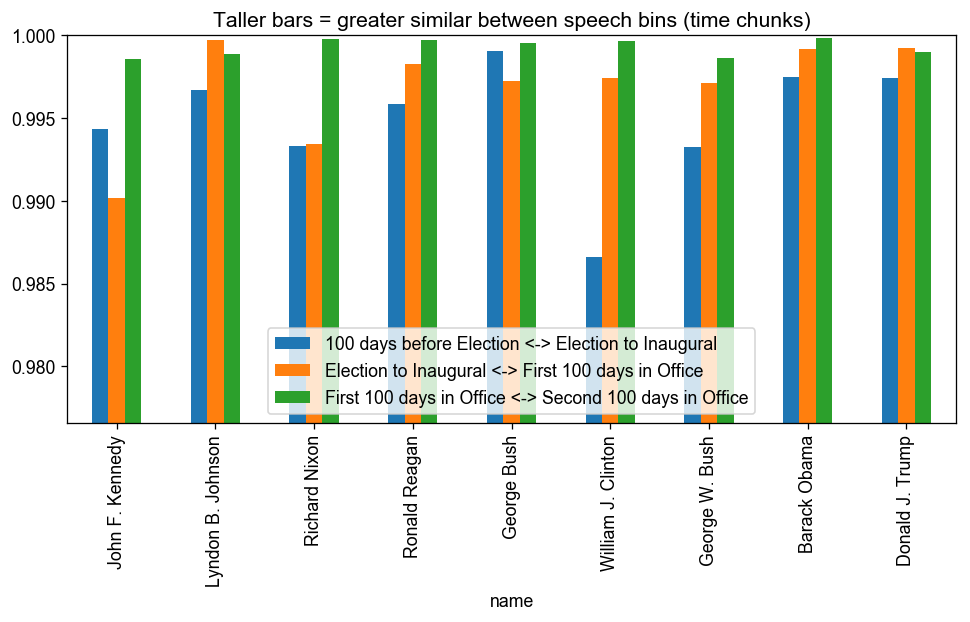

In [73]:
df[similarity_columns].plot(kind='bar')
ymin = df[similarity_columns].min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xticks(rotation=90)
plt.legend(loc='lower center')
plt.title('Taller bars = greater similar between speech bins (time chunks)')
plt.tight_layout()
plt.savefig('Recent_presidents_pre-post-inaugural-100d-similarity.pdf')